In [16]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt


In [17]:
path = 'data/processed_data/coded_data/*.csv'

frames = []

# Process each file in chunks
for fname in glob.glob(path):
    chunks = pd.read_csv(fname, chunksize=500000)  
    for chunk in chunks:
        frames.append(chunk)

all_data = pd.concat(frames)

print("Data successfully loaded in chunks.")


Data successfully loaded in chunks.


In [18]:
print(all_data.columns)

for col in all_data.columns:
    print(col, all_data[col].isnull().sum())

Index(['Unnamed: 0', 'as_of_year', 'respondent_id', 'agency_code', 'loan_type',
       'property_type', 'loan_purpose', 'owner_occupancy', 'loan_amount_000s',
       'preapproval', 'action_taken', 'msamd', 'state_code', 'county_code',
       'census_tract_number', 'applicant_ethnicity', 'co_applicant_ethnicity',
       'applicant_race_1', 'applicant_race_2', 'applicant_race_3',
       'applicant_race_4', 'applicant_race_5', 'co_applicant_race_1',
       'co_applicant_race_2', 'co_applicant_race_3', 'co_applicant_race_4',
       'co_applicant_race_5', 'applicant_sex', 'co_applicant_sex',
       'applicant_income_000s', 'purchaser_type', 'denial_reason_1',
       'denial_reason_2', 'denial_reason_3', 'rate_spread', 'hoepa_status',
       'lien_status', 'edit_status', 'sequence_number', 'population',
       'minority_population', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units', 'application_date_indicator

In [19]:
# Column Filtering

X_indicators = all_data[['as_of_year', 'loan_type',
       'owner_occupancy', 'loan_amount_000s',
       'preapproval', 'applicant_income_000s', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units', 'applicant_ethnicity',
       'co_applicant_ethnicity', 'applicant_race_1', 'co_applicant_race_1',
       'applicant_sex', 'co_applicant_sex', 'minority_population']]

y = all_data['loan_approval']

In [20]:
# Reducing data s.t. each sensitive attribute has the same number of entries in the data,

# change based on current attribute analysis (uncomment the below code to run experiment).
# sensitive_feature = 'applicant_race_1'

# min_count = X_indicators[sensitive_feature].value_counts().min()
# X_indicators = (
#     X_indicators.groupby(sensitive_feature)
#     .apply(lambda x: x.sample(n=min_count, random_state=42))
#     .reset_index(drop=True)
# )

# print(X_indicators[sensitive_feature].value_counts())

In [21]:
# 1-Hot for necessary features

columns_to_encode = ['applicant_ethnicity','co_applicant_ethnicity', 'applicant_race_1', 'co_applicant_race_1','applicant_sex', 'co_applicant_sex']
X_indicators_1hot = pd.get_dummies(X_indicators, columns=columns_to_encode, drop_first=True)

In [22]:
# Train / Test split. Keeping order the parallel is important to check fairness metrics.

# split_index = int(0.7 * len(all_data))
# X_train_uf, X_test_uf, y_train, y_test = all_data.iloc[:split_index, :-1], all_data.iloc[split_index:, :-1], all_data.iloc[:split_index, -1], all_data.iloc[split_index:, -1]
# X_train_f, X_test_f = X_train_uf.iloc[:, :-28], X_test_uf.iloc[:, :-28]
X_train_uf, X_test_uf, y_train, y_test = train_test_split(X_indicators_1hot, y, test_size=0.3, shuffle=False)
X_train_f, X_test_f = X_train_uf.iloc[:, :-28], X_test_uf.iloc[:, :-28]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

         0.0       0.21      0.44      0.29     17664
         1.0       0.84      0.65      0.73     80235

    accuracy                           0.61     97899
   macro avg       0.53      0.54      0.51     97899
weighted avg       0.73      0.61      0.65     97899

Precision-Recall AUC: 0.8518533775294961


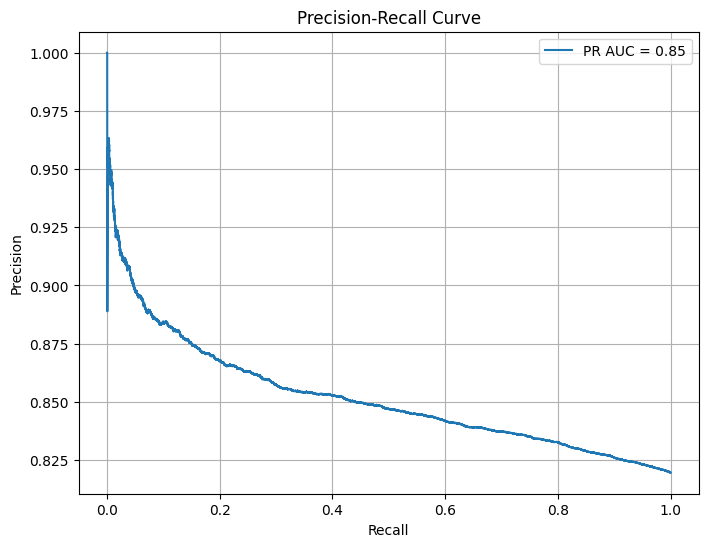

In [23]:
# Logistic Regression:

model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_f, y_train)

# Predict on the test set
y_pred_fl = model.predict(X_test_f)
y_pred_prob_fl = model.predict_proba(X_test_f)[:, 1]  # Get probabilities for Precision-Recall

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_fl))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_fl)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

Classification Report:
              precision    recall  f1-score   support

         0.0       0.24      0.43      0.31     17664
         1.0       0.85      0.70      0.77     80235

    accuracy                           0.65     97899
   macro avg       0.54      0.56      0.54     97899
weighted avg       0.74      0.65      0.68     97899

Precision-Recall AUC: 0.859073829006573


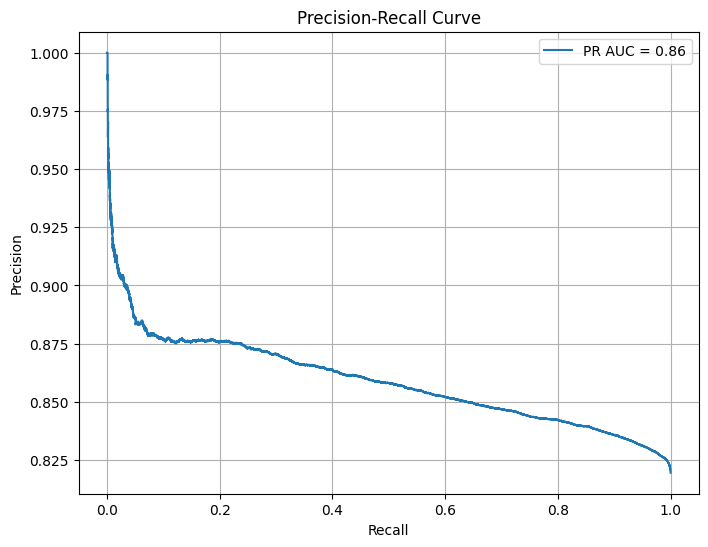

In [24]:
# Train a simple Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=15, # Maximum depth of each tree (adjustable)
    min_samples_split=5, 
    min_samples_leaf=2,
    class_weight={0: 5, 1: 1}, # Higher weight for minority class
    random_state=42    # For reproducibility
)
rf_model.fit(X_train_f, y_train)

# Predict on the test set
y_pred_fr = rf_model.predict(X_test_f)
y_pred_prob_fr = rf_model.predict_proba(X_test_f)[:, 1]  # Get probabilities for Precision-Recall

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_fr))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_fr)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

         0.0       0.23      0.43      0.30     17664
         1.0       0.84      0.68      0.75     80235

    accuracy                           0.64     97899
   macro avg       0.54      0.55      0.53     97899
weighted avg       0.73      0.64      0.67     97899

Precision-Recall AUC: 0.8563433990110438


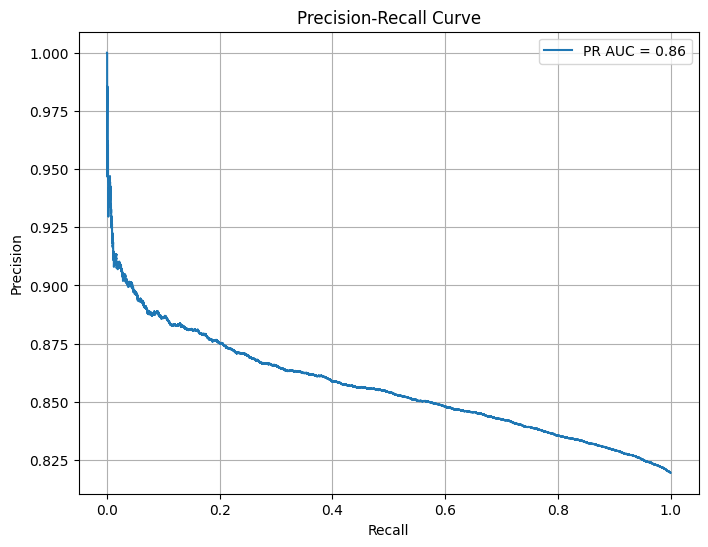

In [25]:
# Logistic Regression:

model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_uf, y_train)

# Predict on the test set
y_pred_ufl = model.predict(X_test_uf)
y_pred_prob_ufl = model.predict_proba(X_test_uf)[:, 1]  # Get probabilities for Precision-Recall

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_ufl))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_ufl)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

Classification Report:
              precision    recall  f1-score   support

         0.0       0.24      0.44      0.31     17664
         1.0       0.85      0.69      0.76     80235

    accuracy                           0.65     97899
   macro avg       0.54      0.57      0.54     97899
weighted avg       0.74      0.65      0.68     97899

Precision-Recall AUC: 0.8620277628378928


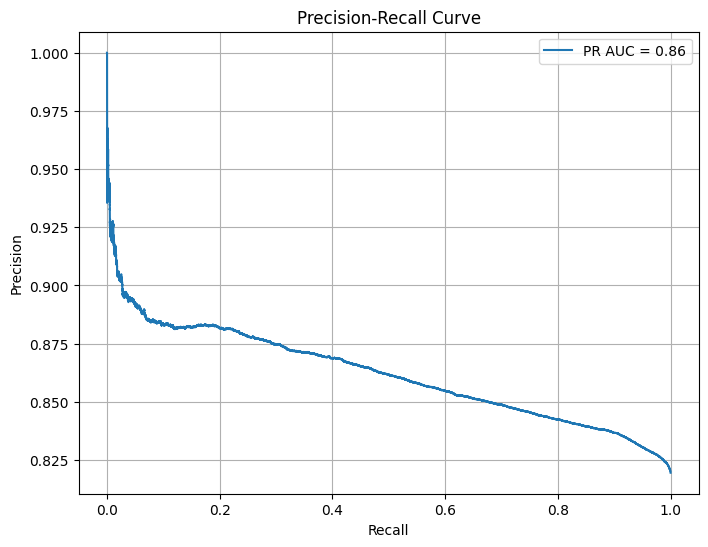

In [26]:
# Train a simple Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=15, # Maximum depth of each tree (adjustable)
    min_samples_split=5, 
    min_samples_leaf=2,
    class_weight={0: 5, 1: 1}, # Higher weight for minority class
    random_state=42    # For reproducibility
)
rf_model.fit(X_train_uf, y_train)

# Predict on the test set
y_pred_ufr = rf_model.predict(X_test_uf)
y_pred_prob_ufr = rf_model.predict_proba(X_test_uf)[:, 1]  # Get probabilities for Precision-Recall

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_ufr))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_ufr)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

In [27]:
split_index = int(0.7 * len(all_data))
X_indicators_test = X_indicators.iloc[split_index:,:-1]

In [28]:
sensitive_features = ['applicant_ethnicity',
       'co_applicant_ethnicity', 'applicant_race_1', 'co_applicant_race_1',
       'applicant_sex', 'co_applicant_sex']


eth_dict = {
    1:"Hispanic or Latino",
    2:"Not Hispanic or Latino",
    3:"No Information Provided by applicant",
    4:"Not Applicable",
    5:"No co-applicant",
}
race_dict = {
    1:"American Indian or Alaska Native",
    2:"Asian",
    3:"Black or African American",
    4:"Native Hawaiian or Other Pacific Islander",
    5:"White",
    6:"No Information Provided by applicant",
    7:"Not Applicable",
    8:"No co-applicant",
}
sex_dict = {
    1:"Male",
    2:"Female",
    3:"No Information Provided by applicant",
    4:"Not Applicable",
    5:"No co-applicant",
}

In [29]:
stat_parity = {}

for feature in sensitive_features:
    groups = X_indicators_test[feature].unique()
    stat_parity[feature] = {}
    
    for group in groups:
        # Get indices for the group
        group_idx = X_indicators_test[feature] == group
        
        # Compute proportion of positive predictions
        positive_rate = y_pred_fr[group_idx].mean()
        stat_parity[feature][group] = positive_rate

# Print results
for feature, groups in stat_parity.items():
    print(f"\nStatistical Parity for {feature}:")
    for group, rate in groups.items():
        if 'ethnicity' in feature:
            print(f"  {eth_dict[group]}: {rate:.2f}")
        elif 'race' in feature:
            print(f"  {race_dict[group]}: {rate:.2f}")
        else:
            print(f"  {sex_dict[group]}: {rate:.2f}")


Statistical Parity for applicant_ethnicity:
  Not Applicable: 0.87
  Not Hispanic or Latino: 0.67
  Hispanic or Latino: 0.58
  No Information Provided by applicant: 0.75

Statistical Parity for co_applicant_ethnicity:
  No co-applicant: 0.65
  Not Hispanic or Latino: 0.70
  No Information Provided by applicant: 0.79
  Hispanic or Latino: 0.64
  Not Applicable: 0.89

Statistical Parity for applicant_race_1:
  Not Applicable: 0.87
  White: 0.68
  Asian: 0.66
  Black or African American: 0.59
  No Information Provided by applicant: 0.75
  Native Hawaiian or Other Pacific Islander: 0.58
  American Indian or Alaska Native: 0.63

Statistical Parity for co_applicant_race_1:
  No co-applicant: 0.65
  White: 0.71
  Asian: 0.68
  No Information Provided by applicant: 0.78
  Black or African American: 0.65
  Native Hawaiian or Other Pacific Islander: 0.65
  American Indian or Alaska Native: 0.64
  Not Applicable: 0.89

Statistical Parity for applicant_sex:
  Not Applicable: 0.87
  Male: 0.67
  F

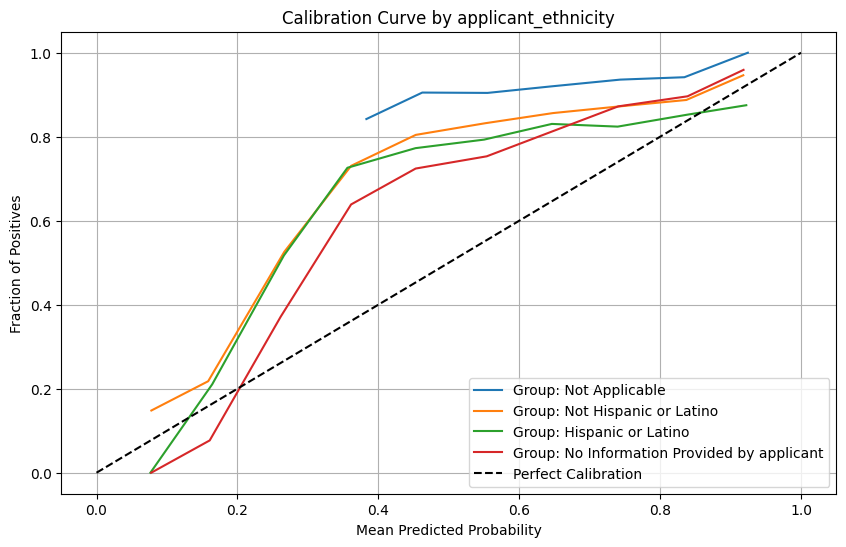

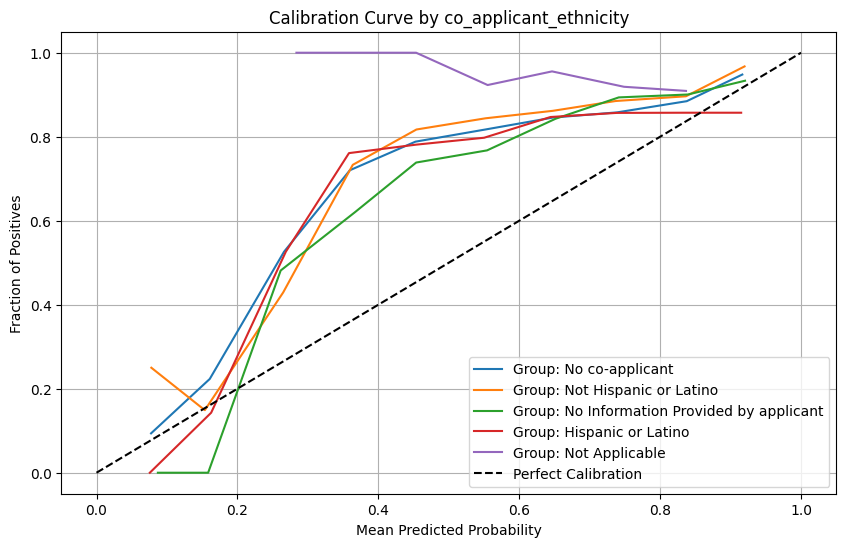

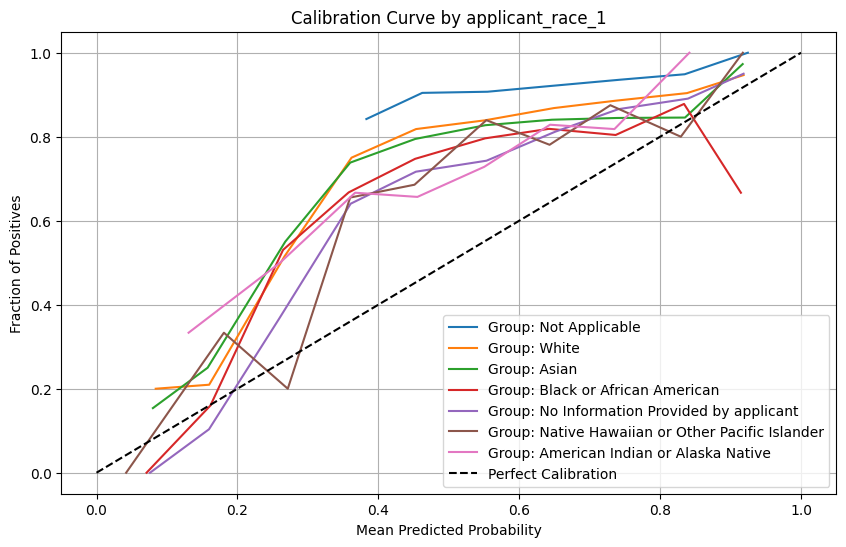

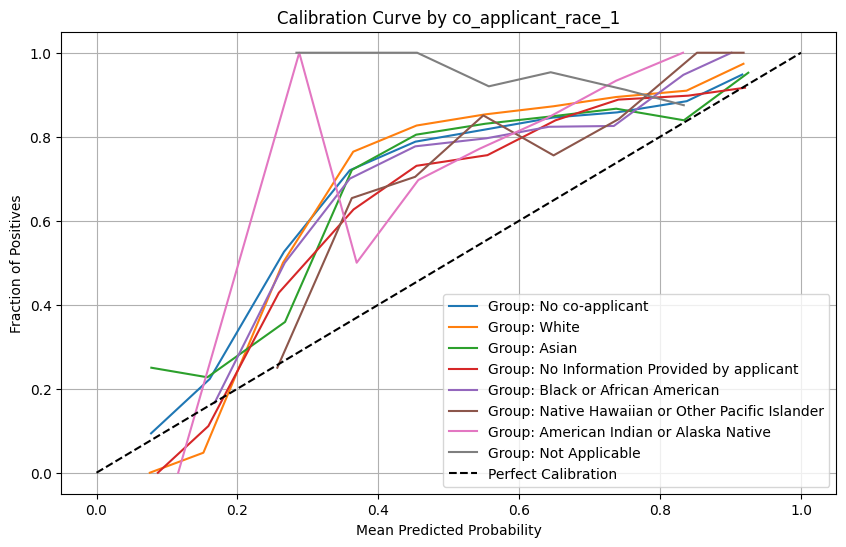

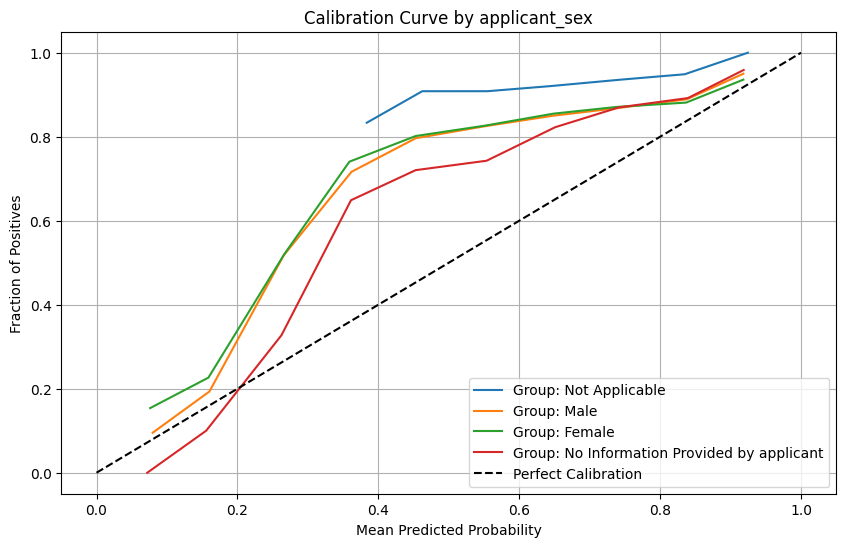

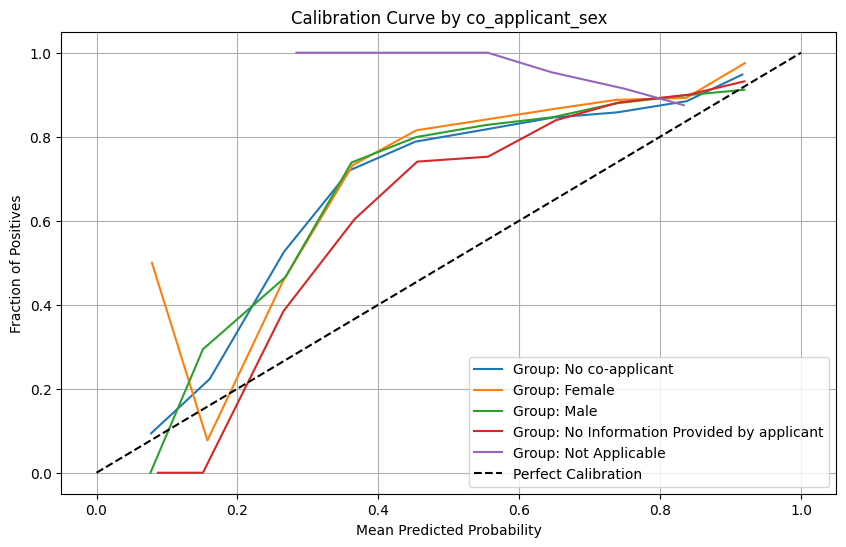

In [30]:
# Calibration for each sensitive feature
calibration_results = {}

for feature in sensitive_features:
    groups = X_indicators_test[feature].unique()
    calibration_results[feature] = {}
    
    for group in groups:
        # Get indices for the group
        group_idx = X_indicators_test[feature] == group
        
        # Get true labels and predicted probabilities for the group
        y_true_group = y_test[group_idx]
        y_prob_group = y_pred_prob_fr[group_idx]
        
        # Compute calibration curve
        prob_true, prob_pred = calibration_curve(y_true_group, y_prob_group, n_bins=10)
        
        calibration_results[feature][group] = (prob_true, prob_pred)

for feature, results in calibration_results.items():
    plt.figure(figsize=(10, 6))
    for group, (prob_true, prob_pred) in results.items():
        if 'ethnicity' in feature:
            plt.plot(prob_pred, prob_true, label=f'Group: {eth_dict[group]}')
        elif 'race' in feature:
            plt.plot(prob_pred, prob_true, label=f'Group: {race_dict[group]}')
        else:
            plt.plot(prob_pred, prob_true, label=f'Group: {sex_dict[group]}')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.title(f'Calibration Curve by {feature}')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid()
    plt.show()
